
# **The *k*-nearest neighbors (*k*NN) regression algorithm**

    Author: Jerónimo Arenas García (jarenas@tsc.uc3m.es)
            Jesús Cid Sueiro (jcid@tsc.uc3m.es)

    Notebook version: 2.2 (Sep 08, 2017)

    Changes: v.1.0 - First version
    Changes: v.1.1 - Stock dataset included.
    Changes: v.2.0 - Notebook for UTAD course. Advertising data incorporated
    Changes: v.2.1 - Text and code revisited. General introduction removed.
    Changes: v.2.2 - Compatibility with python 2 and 3.

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pylab

# Packages used to read datasets
import scipy.io       # To read matlab files
import pandas as pd   # To read datasets in csv format

# For the student tests (only for python 2)
import sys
if sys.version_info.major==2:
    from test_helper import Test

# That's default image size for this interactive session
pylab.rcParams['figure.figsize'] = 9, 6  

## 1. The dataset

We describe next the regression task that we will use in the session. The dataset is an adaptation of the <a href=http://www.dcc.fc.up.pt/~ltorgo/Regression/DataSets.html> `STOCK` dataset</a>, taken originally from the <a href=http://lib.stat.cmu.edu/> StatLib Repository</a>. The goal of this problem is to predict the values of the stocks of a given airplane company, given the values of another 9 companies in the same day. 

<small> If you are reading this text from the python notebook with its full functionality, you can explore the results of the regression experiments using two alternative datasets:

* The 
<a href=https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength>`CONCRETE` dataset</a>, taken from the <a href=https://archive.ics.uci.edu/ml/index.html>Machine Learning Repository at the University of California Irvine</a>. The goal of the `CONCRETE` dataset tas is to predict the compressive strength of cement mixtures based on eight observed variables related to the composition of the mixture and the age of the material). 

* The `Advertising` dataset, taken from the book <a href= http://www-bcf.usc.edu/~gareth/ISL/data.html> An Introduction to Statistical Learning with applications in R</a>, with permission from the authors: G. James, D. Witten, T. Hastie and R. Tibshirani. The goal of this problem is to predict the sales of a given product, knowing the investment in different advertising sectors. More specifically, the input and output variables can be described as follows:

  - *Input features:*
     * TV: advertising dollars spent on TV for a single product in a given market (in thousands of dollars)
     * Radio: advertising dollars spent on Radio
     * Newspaper: advertising dollars spent on Newspaper
     
  - *Response variable:*
     * Sales: sales of a single product in a given market (in thousands of widgets)

To do so, just replace `stock` by `concrete` or `advertising` in the next cell. Remind that you must run the cells again to see the changes. 
</small>

In [2]:
# SELECT dataset
# Available options are 'stock', 'concrete' or 'advertising'
ds_name = 'stock'

In [3]:
# Let us start by loading the data into the workspace, and visualizing the dimensions of all matrices
if ds_name == 'stock':
    # STOCK DATASET
    data = scipy.io.loadmat('datasets/stock.mat')
    X_tr = data['xTrain']
    S_tr = data['sTrain']
    X_tst = data['xTest']
    S_tst = data['sTest']

elif ds_name == 'concrete':
    # CONCRETE DATASET. 
    data = scipy.io.loadmat('datasets/concrete.mat')
    X_tr = data['X_tr']
    S_tr = data['S_tr']
    X_tst = data['X_tst']
    S_tst = data['S_tst']

elif ds_name == 'advertising':    
    # ADVERTISING DATASET
    df = pd.read_csv('datasets/Advertising.csv', header=0)
    X_tr = df.values[:150, 1:4]
    S_tr = df.values[:150, [-1]]   # The brackets around -1 is to make sure S_tr is a column vector, as in the other datasets
    X_tst = df.values[150:, 1:4]
    S_tst = df.values[150:, [-1]]

else:
    print('Unknown dataset')

In [4]:
# Print the data dimension and the dataset sizes
print("SELECTED DATASET: " + ds_name)
print("---- The size of the training set is {0}, that is: {1} samples with dimension {2}.".format(
    X_tr.shape, X_tr.shape[0], X_tr.shape[1]))
print("---- The target variable of the training set contains {0} samples with dimension {1}".format(
    S_tr.shape[0], S_tr.shape[1]))
print("---- The size of the test set is {0}, that is: {1} samples with dimension {2}.".format(
    X_tst.shape, X_tst.shape[0], X_tst.shape[1]))
print("---- The target variable of the test set contains {0} samples with dimension {1}".format(
    S_tst.shape[0], S_tst.shape[1]))

SELECTED DATASET: stock
---- The size of the training set is (380, 9), that is: 380 samples with dimension 9.
---- The target variable of the training set contains 380 samples with dimension 1
---- The size of the test set is (190, 9), that is: 190 samples with dimension 9.
---- The target variable of the test set contains 190 samples with dimension 1


### 1.1. Scatter plots

We can get a first rough idea about the regression task representing the *scatter plot* of each of the one-dimensional variables against the target data. 

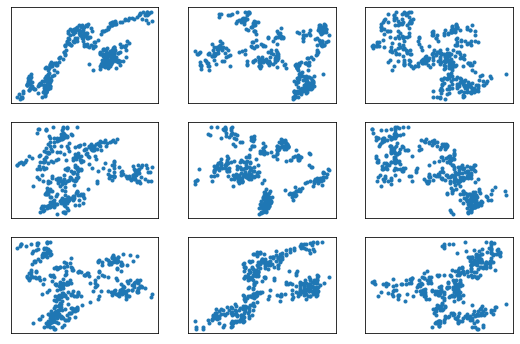

In [5]:
pylab.subplots_adjust(hspace=0.2)
for idx in range(X_tr.shape[1]):
    ax1 = plt.subplot(3,3,idx+1)
    ax1.plot(X_tr[:,idx],S_tr,'.')
    ax1.get_xaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])
plt.show()

## 2. Baseline estimation. Using the average of the training set labels

A first very simple method to build the regression model is to use the average of all the target values in the training set as the output of the model, discarding the value of the observation input vector.

This approach can be considered as a baseline, given that any other method making an effective use of the observation variables, statistically related to $s$, should improve the performance of this method.

The prediction is thus given by

In [6]:
# Mean of all target values in the training set
s_hat = np.mean(S_tr)
print(s_hat)

47.148355263157896


for any input ${\bf x}$.

##### Exercise 1

Compute the mean square error over training and test sets, for the baseline estimation  method.

In [7]:
# We start by defining a function that calculates the average square error
def square_error(s, s_est):
    # Squeeze is used to make sure that s and s_est have the appropriate dimensions.
    y = np.mean(np.power((s - s_est), 2))
    # y = np.mean(np.power((np.squeeze(s) - np.squeeze(s_est)), 2))
    return y

# Mean square error of the baseline prediction over the training data
# MSE_tr = <FILL IN>
MSE_tr = square_error(S_tr, s_hat)

# Mean square error of the baseline prediction over the test data
# MSE_tst = <FILL IN>
MSE_tst = square_error(S_tst, s_hat)

print('Average square error in the training set (baseline method): {0}'.format(MSE_tr))
print('Average square error in the test set (baseline method): {0}'.format(MSE_tst))    

Average square error in the training set (baseline method): 44.14341012378809
Average square error in the test set (baseline method): 43.799266901835175


Note that in the previous piece of code, function 'square_error' can be used when the second argument is a number instead of a vector with the same length as the first argument. The value will be subtracted from each of the components of the vector provided as the first argument.

In [8]:
if sys.version_info.major == 2:
    Test.assertTrue(np.isclose(MSE_tr, square_error(S_tr, s_hat)),'Incorrect value for MSE_tr')
    Test.assertTrue(np.isclose(MSE_tst, square_error(S_tst, s_hat)),'Incorrect value for MSE_tst')

## 3. Unidimensional regression with the $k$-nn method

The principles of the $k$-nn method are the following:

   - For each point where a prediction is to be made, find the $k$ closest neighbors to that point (in the training set)
   - Obtain the estimation averaging the labels corresponding to the selected neighbors
   
The number of neighbors is a hyperparameter that plays an important role in the performance of the method. You can test its influence by changing $k$ in the following piece of code. In particular, you can sart with $k=1$ and observe the efect of increasing the value of $k$.

In [9]:
# We implement unidimensional regression using the k-nn method
# In other words, the estimations are to be made using only one variable at a time

from scipy import spatial

var = 0 # pick a variable (e.g., any value from 0 to 8 for the STOCK dataset)
k = 1  # Number of neighbors
n_points = 1000 # Number of points in the 'x' axis (for representational purposes)

# For representational purposes, we will compute the output of the regression model
# in a series of equally spaced-points along the x-axis
grid_min = np.min([np.min(X_tr[:,var]), np.min(X_tst[:,var])])
grid_max = np.max([np.max(X_tr[:,var]), np.max(X_tst[:,var])])
X_grid = np.linspace(grid_min,grid_max,num=n_points)

def knn_regression(X1, S1, X2, k):
    """ Compute the k-NN regression estimate for the observations contained in
        the rows of X2, for the training set given by the rows in X1 and the
        components of S1. k is the number of neighbours of the k-NN algorithm
    """
    if X1.ndim == 1:
        X1 = np.asmatrix(X1).T
    if X2.ndim == 1:
        X2 = np.asmatrix(X2).T
    distances = spatial.distance.cdist(X1,X2,'euclidean')
    neighbors = np.argsort(distances, axis=0, kind='quicksort', order=None)
    closest = neighbors[range(k),:]
    
    est_values = np.zeros([X2.shape[0],1])
    for idx in range(X2.shape[0]):
        est_values[idx] = np.mean(S1[closest[:,idx]])
        
    return est_values

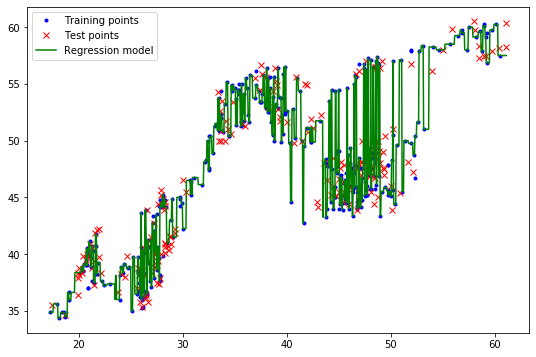

In [10]:
est_tst = knn_regression(X_tr[:,var], S_tr, X_tst[:,var], k)
est_grid = knn_regression(X_tr[:,var], S_tr, X_grid, k)

plt.plot(X_tr[:,var], S_tr,'b.',label='Training points')
plt.plot(X_tst[:,var], S_tst,'rx',label='Test points')
plt.plot(X_grid, est_grid,'g-',label='Regression model')
plt.axis('tight')
plt.legend(loc='best')
plt.show()

### 3.1. Evolution of the error with the number of neighbors ($k$)

We see that a small $k$ results in a regression curve that exhibits many and large oscillations.  The curve is capturing any noise that may be present in the training data, and <i>overfits</i> the training set. On the other hand, picking a too large $k$ (e.g., 200) the regression curve becomes too smooth, averaging out the values of the labels in the training set over large intervals of the observation variable.

The next code illustrates this effect by plotting the average training and test square errors as a function of $k$. 

In [11]:
var = 0
k_max = 60

k_max = np.minimum(k_max, X_tr.shape[0])  # k_max cannot be larger than the number of samples

#Be careful with the use of range, e.g., range(3) = [0,1,2] and range(1,3) = [1,2]
MSEk_tr = [square_error(S_tr, knn_regression(X_tr[:,var], S_tr, X_tr[:,var],k)) 
           for k in range(1, k_max+1)]
MSEk_tst = [square_error(S_tst,knn_regression(X_tr[:,var], S_tr, X_tst[:,var],k)) 
            for k in range(1, k_max+1)]

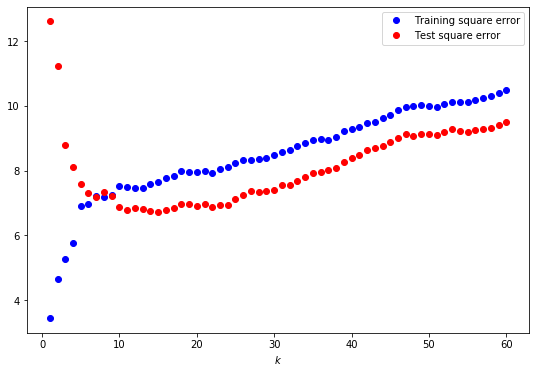

In [12]:
kgrid = np.arange(1, k_max+1)
plt.plot(kgrid, MSEk_tr,'bo', label='Training square error')
plt.plot(kgrid, MSEk_tst,'ro', label='Test square error')
plt.xlabel('$k$')
plt.axis('tight')

plt.legend(loc='best')
plt.show()

As we can see, the error initially decreases achiving a minimum (in the test set) for some finite value of $k$ ($k\approx 10$ for the `STOCK` dataset). Increasing the value of $k$ beyond that value results in poorer performance.

#### Exercise 2

Analize the training MSE for $k=1$. Why is it smaller than for any other $k$? Under which conditions will it be exactly zero?

#### Exercise 3

Modify the code above to visualize the square error from $k=1$ up to $k$ equal to the number of training instances. Can you relate the square error of the $k$-NN method with that of the baseline method for certain value of $k$? 

### 3.1. Influence of the input variable

Having a look at the scatter plots, we can observe that some observation variables seem to have a more clear relationship with the target value. Thus, we can expect that not all variables are equally useful for the regression task. In the following plot, we carry out a study of the performance that can be achieved with each variable. 

Note that, in practice, the test labels are not available for the selection of hyperparameter
$k$, so we should be careful about the conclusions of this experiment. A more realistic approach will be studied later when we introduce the concept of model validation.

In [13]:
k_max = 20

var_performance = []
k_values = []

for var in range(X_tr.shape[1]):
    
    MSE_tr = [square_error(S_tr, knn_regression(X_tr[:,var], S_tr, X_tr[:, var], k)) 
              for k in range(1, k_max+1)]
    MSE_tst = [square_error(S_tst, knn_regression(X_tr[:,var], S_tr, X_tst[:, var], k)) 
               for k in range(1, k_max+1)]
    MSE_tr = np.asarray(MSE_tr)
    MSE_tst = np.asarray(MSE_tst)

    # We select the variable associated to the value of k for which the training error is minimum
    pos = np.argmin(MSE_tr)
    k_values.append(pos + 1)
    var_performance.append(MSE_tst[pos])

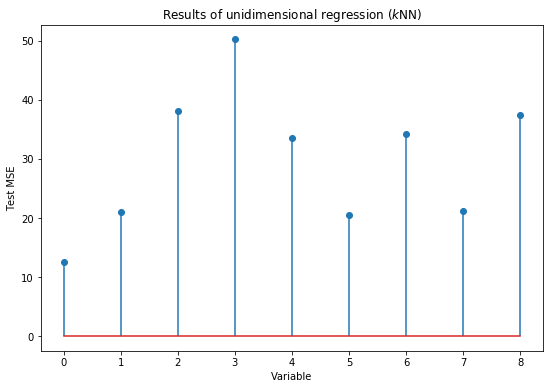

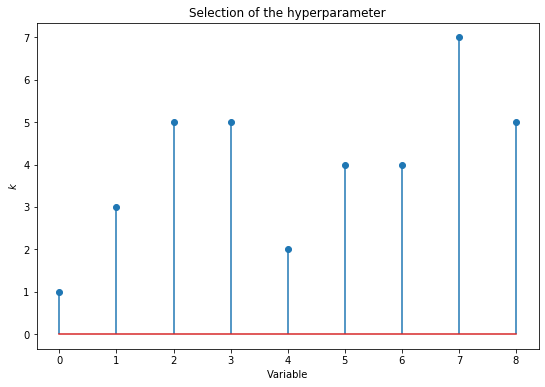

In [14]:
plt.stem(range(X_tr.shape[1]), var_performance, use_line_collection=True)
plt.title('Results of unidimensional regression ($k$NN)')
plt.xlabel('Variable')
plt.ylabel('Test MSE')

plt.figure(2)
plt.stem(range(X_tr.shape[1]), k_values, use_line_collection=True)
plt.xlabel('Variable')
plt.ylabel('$k$')
plt.title('Selection of the hyperparameter')
plt.show()

## 4. Multidimensional regression with the $k$-nn method

In the previous subsection, we have studied the performance of the $k$-nn method when using only one variable. Doing so was convenient, because it allowed us to plot the regression curves in a 2-D plot, and to get some insight about the consequences of modifying the number of neighbors.

For completeness, we evaluate now the performance of the $k$-nn method in this dataset when using all variables together. In fact, when designing a regression model, we should proceed in this manner, using all available information to make as accurate an estimation as possible. In this way, we can also account for correlations that might be present among the different observation variables, and that may carry very relevant information for the regression task.

For instance, in the `STOCK` dataset, it may be that the combination of the stock values of two airplane companies is more informative about the price of the target company, while the value for a single company is not enough.

<small> Also, in the `CONCRETE` dataset, it may be that for the particular problem at hand the combination of a large proportion of water and a small proportion of coarse grain is a clear indication of certain compressive strength of the material, while the proportion of water or coarse grain alone are not enough to get to that result.</small>


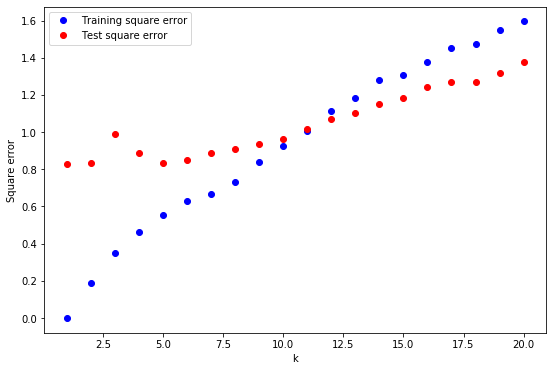

In [15]:
k_max = 20

MSE_tr = [square_error(S_tr, knn_regression(X_tr, S_tr, X_tr, k)) for k in range(1, k_max+1)]
MSE_tst = [square_error(S_tst, knn_regression(X_tr, S_tr, X_tst, k)) for k in range(1, k_max+1)]

plt.plot(np.arange(k_max)+1, MSE_tr,'bo',label='Training square error')
plt.plot(np.arange(k_max)+1, MSE_tst,'ro',label='Test square error')
plt.xlabel('k')
plt.ylabel('Square error')

plt.legend(loc='best')
plt.show()

In this case, we can check that the average test square error is much lower than the error that was achieved when using only one variable, and also far better than the baseline method. It is also interesting to note that in this particular case the best performance is achieved for a small value of $k$, with the error increasing for larger values of the hyperparameter.

Nevertheless, as we discussed previously, these results should be taken carefully. How would we select the value of $k$, if test labels are (obvioulsy) not available for model validation?

## 5. Hyperparameter selection via cross-validation

### 5.1. Generalization

An inconvenient of the application of the $k$-nn method is that the selection of $k$ influences the final error of the algorithm. In the previous experiments, we kept the value of $k$ that minimized the square error on the training set. However, we also noticed that the location of the minimum is not necessarily the same from the perspective of the test data. Ideally, we would like that the designed regression model works as well as possible on future unlabeled patterns that are not available during the training phase. This property is known as <b>generalization</b>. 

Fitting the training data is only pursued in the hope that we are also indirectly obtaining a model that generalizes well. In order to achieve this goal, there are some strategies that try to guarantee a correct generalization of the model. One of such approaches is known as <b>cross-validation</b> 

### 5.2. Cross-validation

Since using the test labels during the training phase is not allowed (they should be kept aside to simultate the future application of the regression model on unseen patterns), we need to figure out some way to improve our estimation of the hyperparameter that requires only training data. Cross-validation allows us to do so by following the following steps:

   - **Split** the training data into several (generally non-overlapping) subsets. If we use $M$ subsets, the method is referred to as $M$-fold cross-validation. If we consider each pattern a different subset, the method is usually referred to as leave-one-out (LOO) cross-validation.
   - Carry out the **training** of the system $M$ times. For each run, use a different partition as a <i>validation</i> set, and use the restating partitions as the training set. Evaluate the performance for different choices of the hyperparameter (i.e., for different values of $k$ for the $k$-NN method).
   - **Average** the validation error over all partitions, and pick the hyperparameter that provided the minimum validation error.
   - **Rerun** the algorithm using all the training data, keeping the value of the parameter that came out of the cross-validation process.
   
<img src="https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png">

In [16]:
### This fragment of code runs k-nn with M-fold cross validation

# Parameters:
M = 5       # Number of folds for M-cv
k_max = 40  # Maximum value of the k-nn hyperparameter to explore

# First we compute the train error curve, that will be useful for comparative visualization.
MSE_tr = [square_error(S_tr, knn_regression(X_tr, S_tr, X_tr, k)) for k in range(1, k_max+1)]

## M-CV
# Obtain the indices for the different folds
n_tr = X_tr.shape[0]
permutation = np.random.permutation(n_tr)

# Split the indices in M subsets with (almost) the same size. 
set_indices = {i: [] for i in range(M)}
i = 0
for pos in range(n_tr):
    set_indices[i].append(permutation[pos])
    i = (i+1) % M
    
# Obtain the validation errors
MSE_val = np.zeros((1,k_max))
for i in range(M):
    val_indices = set_indices[i]
    
    # Take out the val_indices from the set of indices.
    tr_indices = list(set(permutation) - set(val_indices))
    
    MSE_val_iter = [square_error(S_tr[val_indices], 
                                 knn_regression(X_tr[tr_indices, :], S_tr[tr_indices], 
                                                X_tr[val_indices, :], k)) 
                    for k in range(1, k_max+1)]

    MSE_val = MSE_val + np.asarray(MSE_val_iter).T
    
MSE_val = MSE_val/M

# Select the best k based on the validation error
k_best = np.argmin(MSE_val) + 1

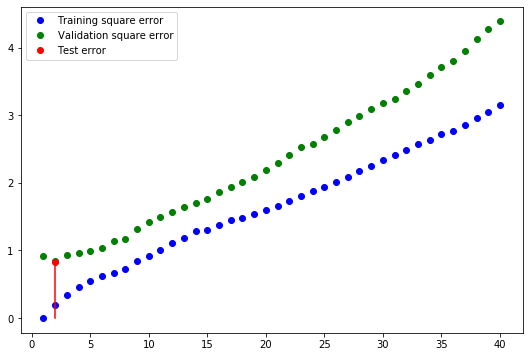

In [17]:
# Compute the final test MSE for the selecte k
MSE_tst = square_error(S_tst, knn_regression(X_tr, S_tr, X_tst, k_best))

plt.plot(np.arange(k_max)+1, MSE_tr, 'bo', label='Training square error')
plt.plot(np.arange(k_max)+1, MSE_val.T, 'go', label='Validation square error')
plt.plot([k_best, k_best], [0, MSE_tst],'r-')
plt.plot(k_best, MSE_tst,'ro',label='Test error')
plt.legend(loc='best')
plt.show()

##### Exercise 4

Modify the previous code to use only one of the variables in the input dataset
  - Following a cross-validation approach, select the best value of $k$ for the $k$-nn based in variable 0 only.
  - Compute the test error for the selected valua of $k$.

## 6. Scikit-learn implementation

In practice, most well-known machine learning methods are implemented and available for python. Probably, the most complete module for machine learning tools is <a href=http://scikit-learn.org/stable/>Scikit-learn</a>. The following piece of code uses the method

    KNeighborsRegressor
   
available in Scikit-learn. The example has been taken from <a href=http://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html>here</a>. As you can check, this routine allows us to build the estimation for a particular point using a weighted average of the targets of the neighbors:

   To obtain the estimation at a point ${\bf x}$:
   
   - Find $k$ closest points to ${\bf x}$ in the training set
   - Average the corresponding targets, weighting each value according to the distance of each point to ${\bf x}$, so that closer points have a larger influence in the estimation.


In [18]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Fabian Pedregosa <fabian.pedregosa@inria.fr>
#
# License: BSD 3 clause (C) INRIA

###############################################################################
# Generate sample data
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors

np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
T = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))

###############################################################################
# Fit regression model
n_neighbors = 5

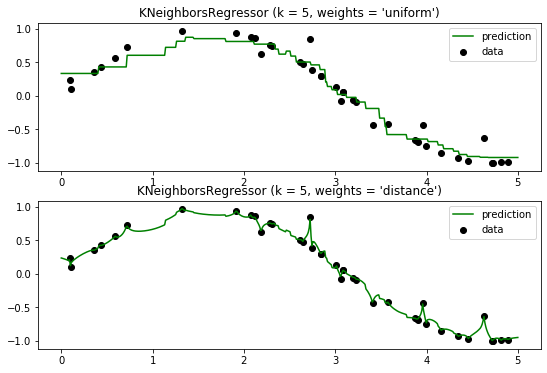

In [19]:
for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_ = knn.fit(X, y).predict(T)

    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot(T, y_, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

#### Exercise 5

Use scikit-learn implementation of the $k$-nn method to compute the generalization error on the `CONCRETE` dataset. Compare the perfomance when using uniform and distance-based weights in the computation the estimates. Visualize the regression curves and error for different values of $k$.